In [ ]:
!pip install -U adapter-transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import re
import torch
from transformers import BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, BertConfig
from transformers import RobertaTokenizer, RobertaConfig, RobertaModelWithHeads, RobertaModel
from transformers import AutoAdapterModel
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
import time
import datetime
import random
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Preparing

dataset = load_dataset("humarin/chatgpt-paraphrases")

# 資料順序隨機選擇
import random
# data_list = list(range(0, len(dataset['train'])))
random_indices = random.sample(range(len(dataset['train'])), 10000)

# 將資料分成0和1
category={}
# for i in range(len(data_list)):
for i in random_indices:

  text = dataset['train'][i]["paraphrases"]
  strings = [text.split("', '")[0][2:], text.split('", "')[0][2:], text.split("\", '")[0][2:], text.split("', \"")[0][2:]]
  text = min(strings, key=len)

  category[text]=1
  category[dataset['train'][i]['text']]=0

# dataset轉成pd
data=pd.DataFrame(category.items(),columns=["text","label"])
data=data.sample(frac=1)

print(data["label"].value_counts())


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

0    10000
1     9989
Name: label, dtype: int64


In [ ]:
# 計算字數的平均長度
def get_label_string_len(data):
  len0=0
  len1=0
  for i in range(0, data.shape[0]):
    if data["label"].values[i]==0:
      len0 += len(data["text"].values[i])
    else:
      len1 += len(data["text"].values[i])

  print(len0/data["label"].value_counts()[0])
  print(len1/data["label"].value_counts()[1])

In [ ]:
# 畫字數的長度圖
def get_label_string_figure(data):
  total_len0 = {}
  total_len1 = {}

  for i in range(0, data.shape[0]):
    text_len = len(data["text"].values[i])
    # if text_len > 250:
      # continue
    # if text_len > 500:
    #   print(f"{data['label'].values[i]} : {data['text'].values[i]}")

    if data["label"].values[i]==0:
      total_len0.setdefault(text_len, 0)
      total_len0[text_len] += 1
    else:
      total_len1.setdefault(text_len, 0)
      total_len1[text_len] += 1

  len0_keys = sorted(total_len0.keys())
  len0_values = [total_len0[key] for key in len0_keys]
  plt.figure(0)
  plt.bar(len0_keys, len0_values)
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.title("Human Number of Words")

  len1_keys = sorted(total_len1.keys())
  len1_values = [total_len1[key] for key in len1_keys]
  plt.figure(1)
  plt.bar(len1_keys, len1_values, color='orange')
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.title("ChatGPT Number of Words")

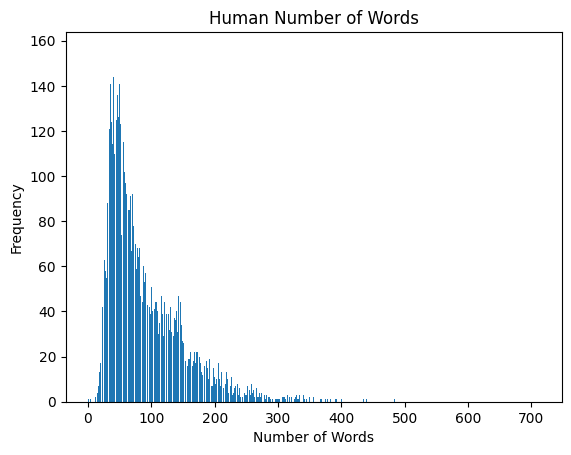

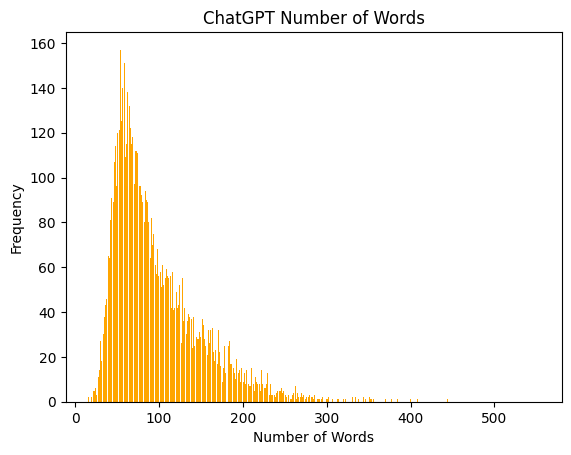

In [ ]:
# get_label_string_len(data)
get_label_string_figure(data)

In [ ]:
# train_size = int(0.9 * len(data))
# val_size = len(data) - train_size


train_df, validation_df = train_test_split(data, random_state=777, test_size=0.1)
# get_label_string_len(train_df)
# get_label_string_len(validation_df)

train_dataset = Dataset.from_dict(train_df)
validation_dataset = Dataset.from_dict(validation_df)
dataset = datasets.DatasetDict({"train":train_dataset,"validation":validation_dataset})
# print(dataset)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
# tokenizer = RobertaTokenizer()
def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=80, truncation=True, padding="max_length")

# Encode the input data
dataset = dataset.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset = dataset.rename_column("label", "labels")
# Transform to pytorch tensors and only output the required columns
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/17990 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

In [ ]:
# pretrain
# config = RobertaConfig.from_pretrained(
#     "roberta-base",
#     num_labels=2,
# )
# model = RobertaModelWithHeads.from_pretrained(
#     "roberta-base",
#     config=config,
# )

# no pretrain
config = RobertaConfig(vocab_size = tokenizer.vocab_size)
model = RobertaModelWithHeads(config=config)

/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/roberta/adapter_model.py:252: FutureWarning: This class has been renamed to `RobertaAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(


Every dataset sample has an input text and a binary label:

In [ ]:
# Add a new adapter
model.add_adapter("rotten_tomatoes")
# Add a matching classification head
model.add_classification_head(
    "rotten_tomatoes",
    num_labels=2
  )
# Activate the adapter
model.train_adapter("rotten_tomatoes")
model.cuda()
pass

In [ ]:
import numpy as np
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction
epochs=10
training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=epochs,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=32,
    logging_steps=1000,
    output_dir="./drive/MyDrive/model/Roberta/output/nopre",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
    evaluation_strategy = "epoch", #To calculate metrics per epoch
    logging_strategy="epoch",
)

# training_args = TrainingArguments(
#     learning_rate=1e-4,
#     num_train_epochs=epochs,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     # prediction_loss_only=False,
#     logging_steps=40,
#     output_dir="./drive/MyDrive/model/Roberta/output",
#     overwrite_output_dir=True,
#     # The next line is important to ensure the dataset labels are properly passed to the model
#     remove_unused_columns=False,
#     evaluation_strategy = "epoch", #To calculate metrics per epoch
#     logging_strategy="epoch",
# )


def compute_metrics(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

# from datasets import load_metric
# metric = load_metric('accuracy')
# def compute_metrics(eval_pred):
#     metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
#     metric={}
#     for met in metrics:
#        metric[met] = load_metric(met)
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     metric_res={}
#     for met in metrics:
#        metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
#     return metric_res


trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
)

In [ ]:
# print(model)

Start the training 🚀

In [ ]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING']="1"
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17990
  Num Epochs = 10
  Instantaneous batch size per device = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 1410
  Number of trainable parameters = 1486658


Epoch,Training Loss,Validation Loss,Acc
1,0.691700,0.671699,0.568784
2,0.664600,0.618506,0.643822
3,0.629500,0.631172,0.625313
4,0.618000,0.576340,0.694847
5,0.597700,0.603515,0.665333
6,0.584800,0.561197,0.696848
7,0.573500,0.554396,0.708354
8,0.564400,0.554837,0.715858
9,0.561200,0.552088,0.714357
10,0.557800,0.552307,0.715858


***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32
Saving model checkpoint to ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500
Configuration saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/adapter_config.json
Module weights saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/pytorch_model_head.bin
Configuration saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/Roberta/output/nopre/checkpoint-500/rotten_tomatoes/pytorch_model_head.b

TrainOutput(global_step=1410, training_loss=0.6043129833032054, metrics={'train_runtime': 1535.3991, 'train_samples_per_second': 117.168, 'train_steps_per_second': 0.918, 'total_flos': 7524130404000000.0, 'train_loss': 0.6043129833032054, 'epoch': 10.0})

In [ ]:
print(trainer.state)

TrainerState(epoch=10.0, global_step=1410, max_steps=1410, num_train_epochs=10, total_flos=7524130404000000.0, log_history=[{'loss': 0.6917, 'learning_rate': 9e-05, 'epoch': 1.0, 'step': 141}, {'eval_loss': 0.6716987490653992, 'eval_acc': 0.568784392196098, 'eval_runtime': 7.948, 'eval_samples_per_second': 251.51, 'eval_steps_per_second': 7.927, 'epoch': 1.0, 'step': 141}, {'loss': 0.6646, 'learning_rate': 8e-05, 'epoch': 2.0, 'step': 282}, {'eval_loss': 0.6185055375099182, 'eval_acc': 0.6438219109554777, 'eval_runtime': 8.2267, 'eval_samples_per_second': 242.99, 'eval_steps_per_second': 7.658, 'epoch': 2.0, 'step': 282}, {'loss': 0.6295, 'learning_rate': 7e-05, 'epoch': 3.0, 'step': 423}, {'eval_loss': 0.6311720609664917, 'eval_acc': 0.6253126563281641, 'eval_runtime': 8.1747, 'eval_samples_per_second': 244.535, 'eval_steps_per_second': 7.707, 'epoch': 3.0, 'step': 423}, {'loss': 0.618, 'learning_rate': 6e-05, 'epoch': 4.0, 'step': 564}, {'eval_loss': 0.5763399004936218, 'eval_acc': 0

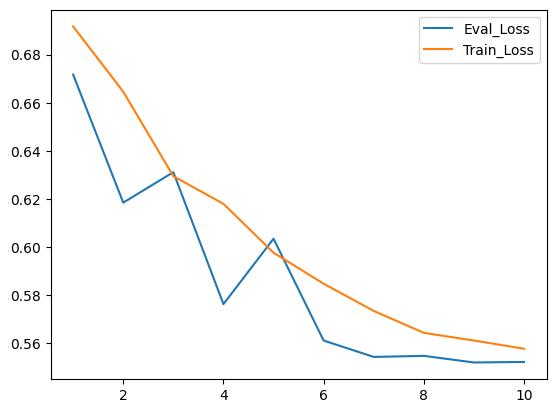

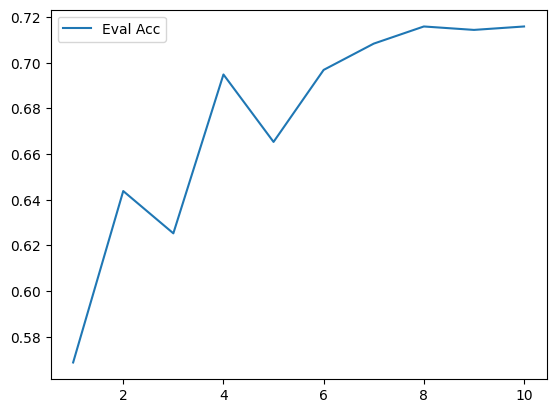

In [ ]:

losses = trainer.state.log_history
x = list(range(1, epochs+1))
plt_train_loss = []
plt_eval_loss = []
plt_eval_acc = []


for loss in losses:
  if 'eval_loss' in loss:
    plt_eval_loss.append(loss['eval_loss'])
    plt_eval_acc.append(loss['eval_acc'])
  elif 'loss' in loss:
    plt_train_loss.append(loss['loss'])


# fig, ax = plt.subplots(figsize = (10, 10))
plt.figure(0)
plt.plot(x, plt_eval_loss, label='Eval_Loss')
plt.plot(x, plt_train_loss, label='Train_Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/model/Roberta/graph/roberta_nopre_loss.png')
plt.figure(1)
plt.plot(x, plt_eval_acc, label='Eval Acc')
plt.legend()
plt.savefig('/content/drive/MyDrive/model/Roberta/graph/roberta_nopre_acc.png')
# plt.savefig('/content/drive/MyDrive/model/Roberta/graph/roberta_train.png')

Looks good! Let's evaluate our adapter on the validation split of the dataset to see how well it learned:

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32


{'eval_loss': 0.5523068904876709,
 'eval_acc': 0.7158579289644822,
 'eval_runtime': 8.1535,
 'eval_samples_per_second': 245.17,
 'eval_steps_per_second': 7.727,
 'epoch': 10.0}

We can put our trained model into a `transformers` pipeline to be able to make new predictions conveniently:

In [ ]:
losses = trainer.state.log_history
x = list(range(0, len(losses)-2))
plt_validation_loss = []


for loss in losses:
  print(loss)
#   if 'loss' in loss:
#     plt_validation_loss.append(loss['loss'])


# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(x, plt_train_loss)
# ax.legend(['validation Loss'])

{'loss': 0.6917, 'learning_rate': 9e-05, 'epoch': 1.0, 'step': 141}
{'eval_loss': 0.6716987490653992, 'eval_acc': 0.568784392196098, 'eval_runtime': 7.948, 'eval_samples_per_second': 251.51, 'eval_steps_per_second': 7.927, 'epoch': 1.0, 'step': 141}
{'loss': 0.6646, 'learning_rate': 8e-05, 'epoch': 2.0, 'step': 282}
{'eval_loss': 0.6185055375099182, 'eval_acc': 0.6438219109554777, 'eval_runtime': 8.2267, 'eval_samples_per_second': 242.99, 'eval_steps_per_second': 7.658, 'epoch': 2.0, 'step': 282}
{'loss': 0.6295, 'learning_rate': 7e-05, 'epoch': 3.0, 'step': 423}
{'eval_loss': 0.6311720609664917, 'eval_acc': 0.6253126563281641, 'eval_runtime': 8.1747, 'eval_samples_per_second': 244.535, 'eval_steps_per_second': 7.707, 'epoch': 3.0, 'step': 423}
{'loss': 0.618, 'learning_rate': 6e-05, 'epoch': 4.0, 'step': 564}
{'eval_loss': 0.5763399004936218, 'eval_acc': 0.6948474237118559, 'eval_runtime': 8.2211, 'eval_samples_per_second': 243.155, 'eval_steps_per_second': 7.663, 'epoch': 4.0, 'step'

In [ ]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)
# RobertaAdapterModel
classifier("How do individuals combat global warming and promote sustainability?")

The model 'RobertaModelWithHeads' is not supported for . Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'EsmForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification', 'GPT2ForSequenceClassification', 'GPTNeoForSequenceClassification', 'GPTJForSequenceClassification', 'IBertForSequenceClassification', 'LayoutLMForSequenceClassification'

[{'label': 'LABEL_0', 'score': 0.8501772284507751}]

At last, we can also extract the adapter from our model and separately save it for later reuse. Note the size difference compared to a full model!

In [ ]:
model_path = "/content/drive/MyDrive/model/Roberta/output/nopre"
model.save_pretrained(model_path)
# model.save_adapter(model_path, "rotten_tomatoes")

# !ls -lh final_adapter

Configuration saved in /content/drive/MyDrive/model/Roberta/output/nopre/config.json
Configuration saved in /content/drive/MyDrive/model/Roberta/output/nopre/generation_config.json
Model weights saved in /content/drive/MyDrive/model/Roberta/output/nopre/pytorch_model.bin


**Share your work!**

The next step after training is to share our adapter with the world via _AdapterHub_. [Read our guide](https://docs.adapterhub.ml/contributing.html) on how to prepare the adapter module we just saved and contribute it to the Hub!

➡️ Also continue with [the next Colab notebook](https://colab.research.google.com/github/Adapter-Hub/adapter-transformers/blob/master/notebooks/02_Adapter_Inference.ipynb) to learn how to use adapters from the Hub.

In [ ]:
model = AutoAdapterModel.from_pretrained(model_path)
model.load_adapter(model_path)

loading configuration file /content/drive/MyDrive/model/Roberta/output/nopre/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/model/Roberta/output/nopre",
  "adapters": {
    "adapters": {
      "rotten_tomatoes": "pfeiffer"
    },
    "config_map": {},
    "fusion_config_map": {},
    "fusions": {}
  },
  "architectures": [
    "RobertaModelWithHeads"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "prediction_heads": {
    "rotten_tomatoes": {
      "activation_function": "tanh",
      "bias": true,
      "head_type": "classification",
      "labe

'rotten_tomatoes'

In [ ]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)
# RobertaAdapterModel
classifier("How do individuals combat global warming and promote sustainability?")

There are adapters available but none are activated for the forward pass.


[{'label': 'LABEL_0', 'score': 0.5318683981895447}]